In [ ]:
!pip install optuna[dashboard] --quiet

In [ ]:
!pip install shap -q

In [ ]:
# ===========================
# RandomForest + SHAP (LabelEncoder + Display Features for Categorical Labels)
# ===========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
from IPython.display import display

# Load dataset
df = pd.read_csv("/content/sample_data/covidstress_processed_data_v2.csv")

# Map target
ordinal_mapping = {"low": 0, "high": 1}
y = df.pop("perceived_stress_level").map(ordinal_mapping)

# Keep raw copy for SHAP display
X_display = df.copy()

# Encode categoricals with LabelEncoder
X_encoded = df.copy()
label_encoders = {}
for col in X_encoded.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le

# Display label encoder mappings
print("\n=== Label Encoder Mappings ===")
for col, encoder in label_encoders.items():
    print(f"\nFeature: {col}")
    print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

np.random.seed(32824)
seeds = np.random.randint(0, 1000, size=5)
n_seeds = len(seeds)

metrics_accumulator = defaultdict(lambda: defaultdict(float))

# === Training and saving model per seed ===
macro_f1_scores = []
weighted_f1_scores = []

for seed in seeds:
    print(f"\n--- Training for Seed: {seed} ---")

    # Split with encoded features
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_encoded, y, test_size=0.2, stratify=y, random_state=seed
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=seed
    )

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 300),
            "max_depth": trial.suggest_int("max_depth", 5, 50),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "random_state": seed,
            "n_jobs": -1
        }
        model = RandomForestClassifier(**params)
        return cross_val_score(model, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1).mean()

    sampler = TPESampler(seed=seed)

    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    study_name = f"xgb_study_seed_{seed}_{timestamp}"


    study = optuna.create_study(
        direction="maximize",
        study_name=study_name,
        storage=f"sqlite:///rf_stress_seed_{seed}.db",
        load_if_exists=False,
        sampler=sampler
    )
    study.optimize(objective, n_trials=30)

    best_params = study.best_params
    model = RandomForestClassifier(**best_params, random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train)

    # Save model and test sets
    joblib.dump(model, f"rf_model_seed_{seed}.pkl")
    joblib.dump(X_test, f"rf_X_test_seed_{seed}.pkl")  # encoded test set
    joblib.dump(X_display.iloc[X_test.index], f"rf_X_display_seed_{seed}.pkl")  # raw labels

    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    report = classification_report(y_val, y_pred, target_names=ordinal_mapping.keys(), output_dict=True)

    # Store macro F1 score per seed
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    macro_f1_scores.append(macro_f1)
    weighted_f1_scores.append(weighted_f1)


    for class_label, scores in report.items():
        if isinstance(scores, dict):
            for metric, value in scores.items():
                metrics_accumulator[class_label][metric] += value

    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=ordinal_mapping.keys(), yticklabels=ordinal_mapping.keys())
    plt.title(f"Validation Confusion Matrix (Seed {seed})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"rf_conf_matrix_validation_seed_{seed}.png")
    plt.close()

print("\n=== Average Metrics Across Seeds ===")
for class_label, metrics in metrics_accumulator.items():
    print(f"\nClass: {class_label}")
    for metric, total in metrics.items():
        print(f"{metric}: {total / n_seeds:.4f}")



[I 2025-10-15 14:04:28,629] A new study created in RDB with name: xgb_study_seed_970_20251015140428



--- Training for Seed: 970 ---


[I 2025-10-15 14:04:37,966] Trial 0 finished with value: 0.6351902161725487 and parameters: {'n_estimators': 264, 'max_depth': 11, 'min_samples_split': 9}. Best is trial 0 with value: 0.6351902161725487.
[I 2025-10-15 14:04:43,291] Trial 1 finished with value: 0.6412077979890414 and parameters: {'n_estimators': 289, 'max_depth': 7, 'min_samples_split': 4}. Best is trial 1 with value: 0.6412077979890414.
[I 2025-10-15 14:04:53,340] Trial 2 finished with value: 0.610870269503725 and parameters: {'n_estimators': 255, 'max_depth': 44, 'min_samples_split': 3}. Best is trial 1 with value: 0.6412077979890414.
[I 2025-10-15 14:05:00,368] Trial 3 finished with value: 0.6113174057105015 and parameters: {'n_estimators': 211, 'max_depth': 47, 'min_samples_split': 3}. Best is trial 1 with value: 0.6412077979890414.
[I 2025-10-15 14:05:09,773] Trial 4 finished with value: 0.6116900913115313 and parameters: {'n_estimators': 238, 'max_depth': 23, 'min_samples_split': 3}. Best is trial 1 with value: 0.

Validation Accuracy: 0.6564

--- Training for Seed: 200 ---


[I 2025-10-15 14:08:01,792] A new study created in RDB with name: xgb_study_seed_200_20251015140801
[I 2025-10-15 14:08:11,018] Trial 0 finished with value: 0.63494718998478 and parameters: {'n_estimators': 290, 'max_depth': 15, 'min_samples_split': 7}. Best is trial 0 with value: 0.63494718998478.
[I 2025-10-15 14:08:17,333] Trial 1 finished with value: 0.6187714536379454 and parameters: {'n_estimators': 186, 'max_depth': 40, 'min_samples_split': 2}. Best is trial 0 with value: 0.63494718998478.
[I 2025-10-15 14:08:23,783] Trial 2 finished with value: 0.6301113792404147 and parameters: {'n_estimators': 171, 'max_depth': 46, 'min_samples_split': 6}. Best is trial 0 with value: 0.63494718998478.
[I 2025-10-15 14:08:31,728] Trial 3 finished with value: 0.6355285901229847 and parameters: {'n_estimators': 297, 'max_depth': 44, 'min_samples_split': 10}. Best is trial 3 with value: 0.6355285901229847.
[I 2025-10-15 14:08:40,801] Trial 4 finished with value: 0.6335623642653756 and parameters:

Validation Accuracy: 0.6548

--- Training for Seed: 20 ---


[I 2025-10-15 14:11:12,812] A new study created in RDB with name: xgb_study_seed_20_20251015141112
[I 2025-10-15 14:11:18,763] Trial 0 finished with value: 0.6166653727151362 and parameters: {'n_estimators': 218, 'max_depth': 46, 'min_samples_split': 10}. Best is trial 0 with value: 0.6166653727151362.
[I 2025-10-15 14:11:23,591] Trial 1 finished with value: 0.6270008925847737 and parameters: {'n_estimators': 263, 'max_depth': 6, 'min_samples_split': 8}. Best is trial 1 with value: 0.6270008925847737.
[I 2025-10-15 14:11:29,344] Trial 2 finished with value: 0.6125738927704869 and parameters: {'n_estimators': 176, 'max_depth': 28, 'min_samples_split': 7}. Best is trial 1 with value: 0.6270008925847737.
[I 2025-10-15 14:11:33,214] Trial 3 finished with value: 0.6147245459727804 and parameters: {'n_estimators': 138, 'max_depth': 17, 'min_samples_split': 8}. Best is trial 1 with value: 0.6270008925847737.
[I 2025-10-15 14:11:41,706] Trial 4 finished with value: 0.6146302573240651 and param

Validation Accuracy: 0.6609


[I 2025-10-15 14:14:05,846] A new study created in RDB with name: xgb_study_seed_452_20251015141405



--- Training for Seed: 452 ---


[I 2025-10-15 14:14:13,439] Trial 0 finished with value: 0.617699142297061 and parameters: {'n_estimators': 278, 'max_depth': 24, 'min_samples_split': 10}. Best is trial 0 with value: 0.617699142297061.
[I 2025-10-15 14:14:19,979] Trial 1 finished with value: 0.6305272609463033 and parameters: {'n_estimators': 276, 'max_depth': 8, 'min_samples_split': 5}. Best is trial 1 with value: 0.6305272609463033.
[I 2025-10-15 14:14:23,553] Trial 2 finished with value: 0.60932095146408 and parameters: {'n_estimators': 106, 'max_depth': 26, 'min_samples_split': 3}. Best is trial 1 with value: 0.6305272609463033.
[I 2025-10-15 14:14:27,454] Trial 3 finished with value: 0.618395119944784 and parameters: {'n_estimators': 128, 'max_depth': 15, 'min_samples_split': 7}. Best is trial 1 with value: 0.6305272609463033.
[I 2025-10-15 14:14:35,761] Trial 4 finished with value: 0.6198970442688762 and parameters: {'n_estimators': 270, 'max_depth': 31, 'min_samples_split': 9}. Best is trial 1 with value: 0.630

Validation Accuracy: 0.6625

--- Training for Seed: 97 ---


[I 2025-10-15 14:17:27,539] A new study created in RDB with name: xgb_study_seed_97_20251015141727
[I 2025-10-15 14:17:36,849] Trial 0 finished with value: 0.6179561560757527 and parameters: {'n_estimators': 268, 'max_depth': 49, 'min_samples_split': 6}. Best is trial 0 with value: 0.6179561560757527.
[I 2025-10-15 14:17:41,851] Trial 1 finished with value: 0.6090623968224425 and parameters: {'n_estimators': 157, 'max_depth': 40, 'min_samples_split': 4}. Best is trial 0 with value: 0.6179561560757527.
[I 2025-10-15 14:17:52,878] Trial 2 finished with value: 0.609535198798998 and parameters: {'n_estimators': 296, 'max_depth': 47, 'min_samples_split': 3}. Best is trial 0 with value: 0.6179561560757527.
[I 2025-10-15 14:17:58,615] Trial 3 finished with value: 0.6234369703862745 and parameters: {'n_estimators': 169, 'max_depth': 14, 'min_samples_split': 4}. Best is trial 3 with value: 0.6234369703862745.
[I 2025-10-15 14:18:04,342] Trial 4 finished with value: 0.6069493654290679 and parame

Validation Accuracy: 0.6519

=== Average Metrics Across Seeds ===

Class: low
precision: 0.6777
recall: 0.7814
f1-score: 0.7258
support: 1433.0000

Class: high
precision: 0.6164
recall: 0.4854
f1-score: 0.5429
support: 1035.0000

Class: macro avg
precision: 0.6471
recall: 0.6334
f1-score: 0.6343
support: 2468.0000

Class: weighted avg
precision: 0.6520
recall: 0.6573
f1-score: 0.6491
support: 2468.0000


In [ ]:
# Analyze stability
print("\n=== F1-Score Stability Analysis ===")
print("Macro F1 - Mean:", np.mean(macro_f1_scores))
print("Macro F1 - Std Dev:", np.std(macro_f1_scores))
print("Macro F1 - Variance:", np.var(macro_f1_scores))

print("Weighted F1 - Mean:", np.mean(weighted_f1_scores))
print("Weighted F1 - Std Dev:", np.std(weighted_f1_scores))
print("Weighted F1 - Variance:", np.var(weighted_f1_scores))


=== F1-Score Stability Analysis ===
Macro F1 - Mean: 0.6343439282735146
Macro F1 - Std Dev: 0.0020224499054136936
Macro F1 - Variance: 4.0903036199078585e-06
Weighted F1 - Mean: 0.6490929932821505
Weighted F1 - Std Dev: 0.0024643476167656064
Weighted F1 - Variance: 6.073009176258324e-06


In [ ]:
# ========== SHAP ANALYSIS FOR RANDOM FOREST (FINAL FIXED VERSION) ==========

shap_values_all = []
X_test_all = []
X_display_all = []

for seed in seeds:
    print(f"\n>> SHAP for Seed: {seed}")

    # Load model and test data
    model = joblib.load(f"rf_model_seed_{seed}.pkl")
    X_test = joblib.load(f"rf_X_test_seed_{seed}.pkl")
    X_disp = joblib.load(f"rf_X_display_seed_{seed}.pkl")

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # ==== Handle SHAP format (list or 3D array) ====
    if isinstance(shap_values, list):
        # Binary case: list of arrays → use class 1
        shap_values_class = shap_values[1]
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        # Newer SHAP versions: shape (n_samples, n_features, n_classes)
        shap_values_class = shap_values[:, :, 1]
    else:
        raise ValueError("Unexpected SHAP output shape")

    # Store aligned SHAP and test sets
    shap_values_all.append(pd.DataFrame(shap_values_class, columns=X_disp.columns))
    X_test_all.append(pd.DataFrame(X_test, columns=X_disp.columns))
    X_display_all.append(X_disp.reset_index(drop=True))

# === Concatenate SHAP and Test Data ===
shap_values_concat = pd.concat(shap_values_all, ignore_index=True)
X_test_concat = pd.concat(X_test_all, ignore_index=True)
X_display_concat = pd.concat(X_display_all, ignore_index=True)




>> SHAP for Seed: 970

>> SHAP for Seed: 200

>> SHAP for Seed: 20

>> SHAP for Seed: 452

>> SHAP for Seed: 97


/tmp/ipython-input-314480661.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_concat.values, X_test_concat, plot_type="bar", feature_names=X_display_concat.columns)


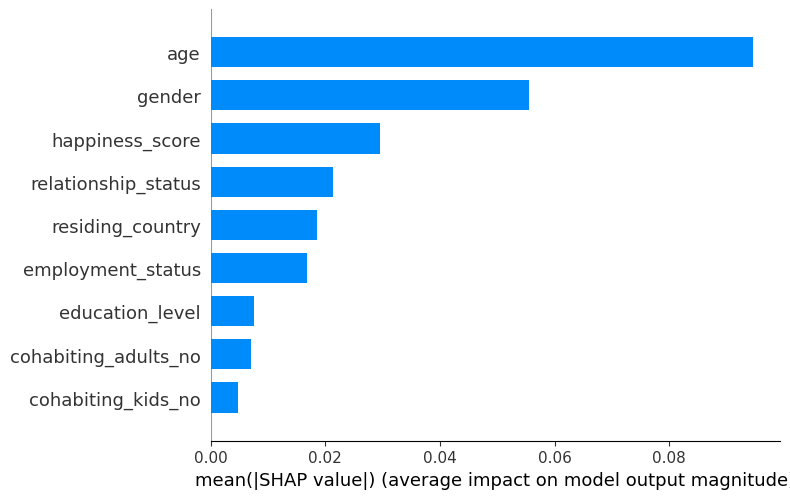

In [ ]:
# SHAP Visualization
shap.initjs()

# Summary bar plot
shap.summary_plot(shap_values_concat.values, X_test_concat, plot_type="bar", feature_names=X_display_concat.columns)

/tmp/ipython-input-2788144498.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_concat.values, X_test_concat, feature_names=X_display_concat.columns)


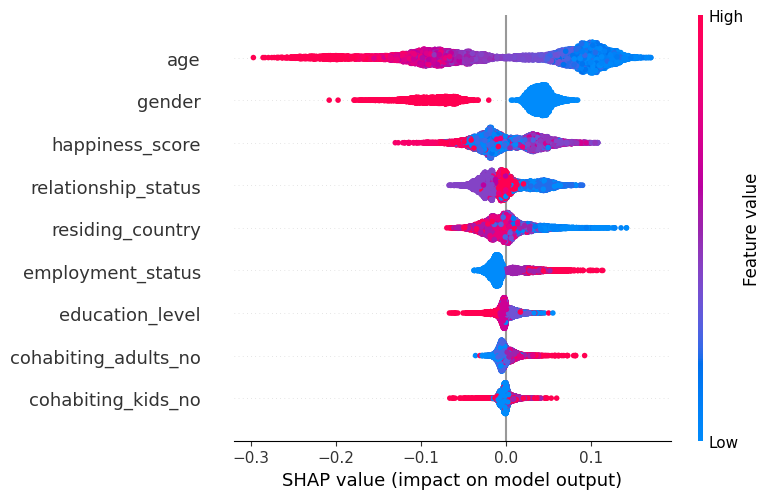

In [ ]:
# Summary dot plot
shap.summary_plot(shap_values_concat.values, X_test_concat, feature_names=X_display_concat.columns)

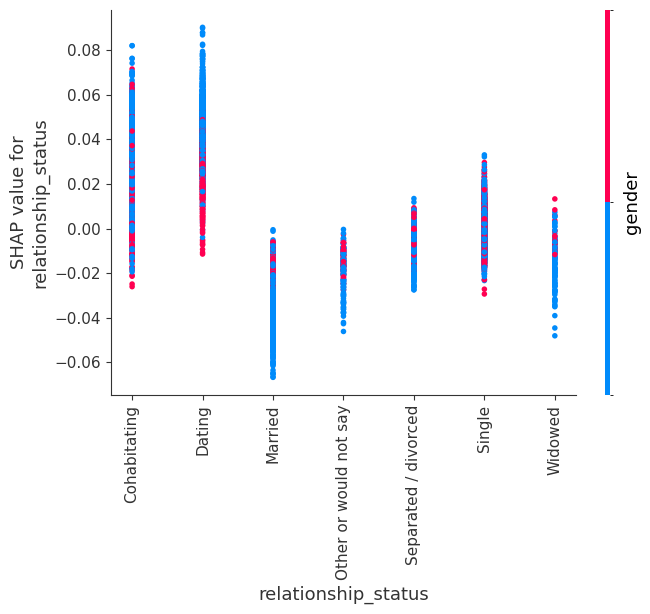

In [ ]:
# Dependence plot
shap.dependence_plot(
    "relationship_status",
    shap_values_concat.values,
    X_test_concat,
    display_features=X_display_concat,
    interaction_index="gender"
)

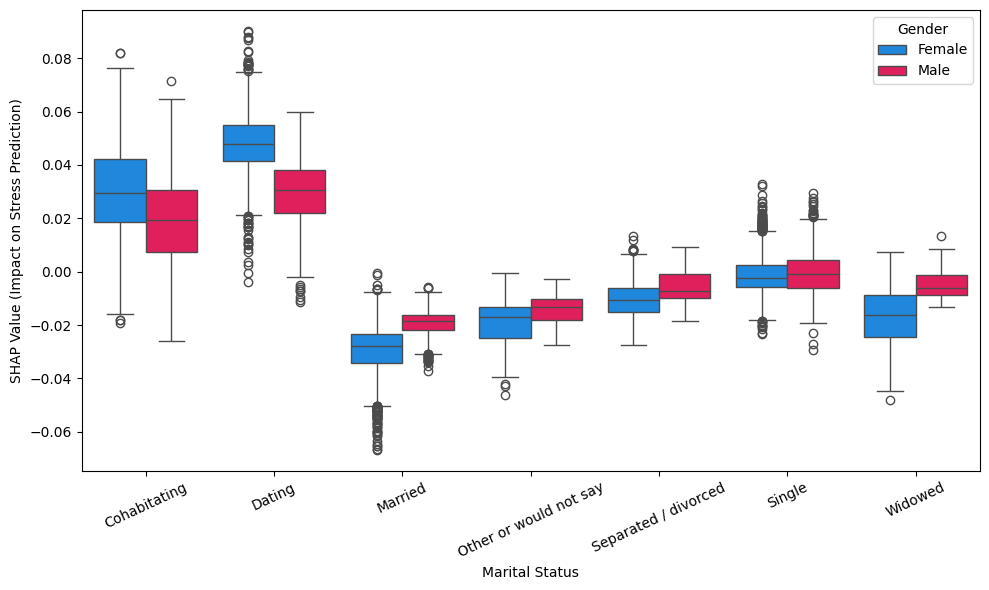


=== Two-Way ANOVA Results ===
                                    sum_sq       df             F    PR(>F)
C(relationship_status)            7.320741      6.0  12646.025262  0.000000
C(gender)                         0.000879      1.0      9.109475  0.002548
C(relationship_status):C(gender)  0.253888      6.0    438.572802  0.000000
Residual                          1.189247  12326.0           NaN       NaN

=== Tukey HSD Post-hoc Test (Marital Status) ===
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
          Cohabitating                 Dating   0.0146    0.0  0.0135  0.0157   True
          Cohabitating                Married  -0.0534    0.0 -0.0544 -0.0525   True
          Cohabitating Other or would not say  -0.0454    0.0 -0.0477 -0.0431   True
          Cohabitating   Sepa

/tmp/ipython-input-3294737652.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["relationship_status", "gender"])["shap_relationship_status"]
/tmp/ipython-input-3294737652.py:74: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(
/tmp/ipython-input-3294737652.py:74: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


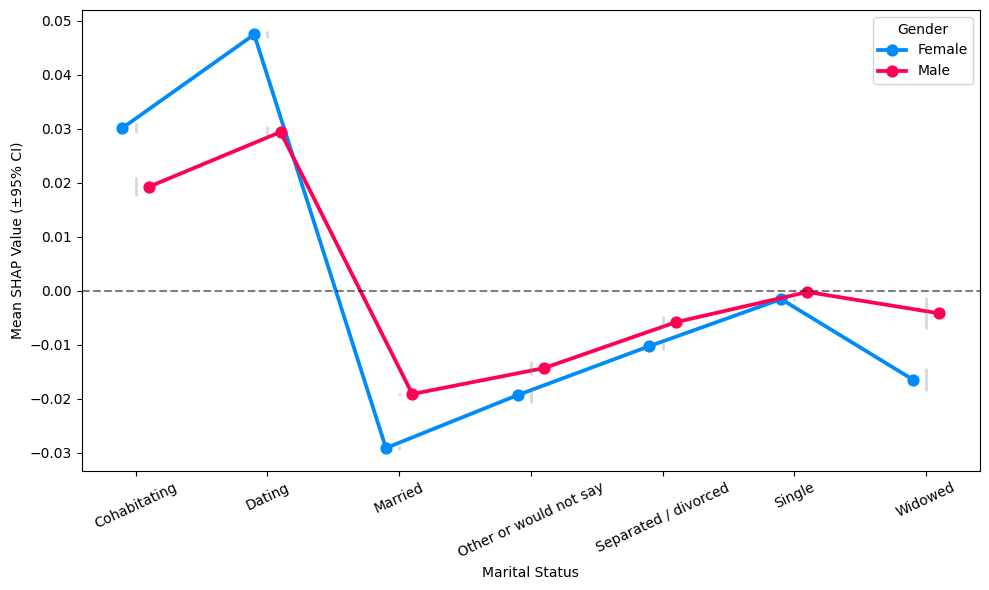


=== Group Means (Estimated Marginal Means) ===
       relationship_status  gender      mean  ci95_low  ci95_high
0             Cohabitating  Female  0.030172  0.029262   0.031083
1             Cohabitating    Male  0.019268  0.017484   0.021051
2                   Dating  Female  0.047492  0.046842   0.048142
3                   Dating    Male  0.029429  0.028368   0.030490
4                  Married  Female -0.029126 -0.029451  -0.028801
5                  Married    Male -0.019119 -0.019356  -0.018882
6   Other or would not say  Female -0.019320 -0.020788  -0.017851
7   Other or would not say    Male -0.014318 -0.015642  -0.012994
8     Separated / divorced  Female -0.010251 -0.010874  -0.009628
9     Separated / divorced    Male -0.005816 -0.006891  -0.004741
10                  Single  Female -0.001538 -0.001821  -0.001256
11                  Single    Male -0.000210 -0.000614   0.000193
12                 Widowed  Female -0.016442 -0.018626  -0.014257
13                 Widowed  

In [ ]:
# ==========================================================
# Two-way ANOVA + Post-hoc Visualization for Marital Status × Gender (Random Forest SHAP)
# ==========================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- Step 1: Prepare SHAP data for ANOVA ---

df_shap = pd.DataFrame({
    "relationship_status": X_display_concat["relationship_status"],
    "gender": X_display_concat["gender"],
    "shap_relationship_status": shap_values_concat["relationship_status"]
})

# Convert to categorical for statsmodels
df_shap["relationship_status"] = df_shap["relationship_status"].astype("category")
df_shap["gender"] = df_shap["gender"].astype("category")


# Drop any rows with missing data
df_shap.dropna(subset=["relationship_status", "gender", "shap_relationship_status"], inplace=True)

# --- Step 2: Visualize raw SHAP distributions ---

gender_color_map = {
    'Female': '#008bfb',  # SHAP blue
    'Male': '#ff0052'     # SHAP red
}

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_shap, x="relationship_status", y="shap_relationship_status", hue="gender", palette=gender_color_map)
#plt.title("Raw SHAP Contributions: Marital Status × Gender")
plt.ylabel("SHAP Value (Impact on Stress Prediction)")
plt.xlabel("Marital Status")
plt.xticks(rotation=25)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

# --- Step 3: Two-Way ANOVA ---
model = ols("shap_relationship_status ~ C(relationship_status) * C(gender)", data=df_shap).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

print("\n=== Two-Way ANOVA Results ===")
print(anova_results)

# --- Step 4: Post-hoc test (Tukey HSD for marital status main effect) ---
tukey = pairwise_tukeyhsd(
    endog=df_shap["shap_relationship_status"],
    groups=df_shap["relationship_status"],
    alpha=0.05
)
print("\n=== Tukey HSD Post-hoc Test (Marital Status) ===")
print(tukey.summary())

# --- Step 5: Estimated Marginal Means (Interaction Plot) ---
emm = (
    df_shap
    .groupby(["relationship_status", "gender"])["shap_relationship_status"]
    .agg(["mean", "count", "std"])
    .reset_index()
)
emm["se"] = emm["std"] / (emm["count"] ** 0.5)
emm["ci95_low"] = emm["mean"] - 1.96 * emm["se"]
emm["ci95_high"] = emm["mean"] + 1.96 * emm["se"]

# --- Step 6: Interaction Plot ---
plt.figure(figsize=(10, 6))
sns.pointplot(
    data=emm,
    x="relationship_status",
    y="mean",
    hue="gender",
    palette=gender_color_map,
    dodge=0.2,
    join=True,
    markers="o",
    errwidth=1.5,
    capsize=0.1
)
for i, row in emm.iterrows():
    plt.vlines(row["relationship_status"], row["ci95_low"], row["ci95_high"],
               colors="gray", alpha=0.3, linewidth=2)
#plt.title("Estimated Marginal Means: Marital Status × Gender (SHAP Impact)")
plt.ylabel("Mean SHAP Value (±95% CI)")
plt.xlabel("Marital Status")
plt.xticks(rotation=25)
plt.axhline(0, color="black", linestyle="--", alpha=0.5)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

# --- Step 7: Optional: Print group means for reporting ---
print("\n=== Group Means (Estimated Marginal Means) ===")
print(emm[["relationship_status", "gender", "mean", "ci95_low", "ci95_high"]])
